# 8 Introduction to deep learning for computer vision

计算机视觉是最早也是最大的深度学习成功故事。每天，您都会通过谷歌照片、谷歌图像搜索、YouTube、相机应用程序中的视频过滤器、OCR软件等与深度视觉模型进行交互。这些模型也是自动驾驶、机器人、人工智能辅助医疗诊断、自主零售结账系统甚至自主农业前沿研究的核心。

计算机视觉是2011年至2015年间深度学习最初兴起的问题领域。大约在那个时候，一种名为卷积神经网络的深度学习模型开始在图像分类竞赛中获得非常好的结果，首先是Dan Ciresan赢得了两个竞赛(ICDAR 2011 中文字符识别竞赛 和 IJCNN 2011 德国交通标志识别竞赛)， 更值得注意的是，在2012年秋季，Hinton的团队赢得了备受瞩目的ImageNet大规模视觉识别挑战。在其他计算机视觉任务中，许多更有希望的结果很快就开始冒泡。

有趣的是，这些早期的成功不足以使深度学习成为当时的主流——这花了几年时间。计算机视觉研究社区花了多年时间投资于神经网络以外的方法，它还没有准备好仅仅因为街区里有一个新孩子就放弃它们。2013年和2014年，深度学习仍然面临许多高级计算机视觉研究人员的强烈怀疑。直到2016年，它才最终占据主导地位。我记得2014年2月，我劝过我的一位前教授转向深度学习。“这是下一件大事！”我会说。“好吧，也许这只是一种时尚，”他回答道。到2016年，他的整个实验室都在进行深度学习。时机已经到来，这是无法阻止的想法。

本章介绍了卷积神经网络，也称为convnets，这是一种深度学习模型，现在几乎普遍用于计算机视觉应用。您将学习将convnet应用于图像分类问题——特别是那些涉及小型训练数据集的问题。

## 8.1 Introduction

我们即将深入研究什么是convnet的理论，以及为什么它们在计算机视觉任务方面如此成功。但首先，让我们实际看看一个简单的convnet示例，该示例对MNIST数字进行分类，这是我们在第2章中使用 Dense 连接的网络执行的任务（当时我们的测试精度为97.8%）。

以下列表显示了基本convnet的样子。这是一堆Conv2D和MaxPooling2D层。你将在一分钟内看到他们到底在做什么。我们将使用我们在上一章中介绍的 Functional API 构建模型。

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Metal device set to: Apple M1


2022-04-05 22:00:54.045616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 22:00:54.046050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


重要的是，convnet作为形状的输入张量 `(image_height、image_width、image_channels)`，不包括 batch 维度。在这种情况下，我们将配置convnet以处理大小 `(28，28，1)` 的输入，这是MNIST图像的格式。

让我们展示一下我们convnet的架构。

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

您可以看到，每个Conv2D和MaxPooling2D层的输出都是形状的 rank-3 张量（高度、宽度、通道）。随着模型变深，宽度和高度尺寸往往会缩小。通道数量由传递给Conv2D层的第一个参数控制(32、64或128)。

在最后一个Conv2D层之后，我们最终得到一个形状为 (3，3，128) 的输出 —— 一个由128个通道组成3×3的特征图。下一步是将该输出输入一个 Dense分类器，就像您已经熟悉的分类器一样：一堆 Dense 层。这些分类器处理1D向量，而当前输出是rank-3张量。为了弥合差距，在添加 Dense 层之前，我们用 flatten 层将3D输出拉平化为1D。

最后，我们进行10分类，因此我们的最后一层有10个输出和一个softmax激活。

现在，让我们在MNIST数字上训练convnet。我们将重用第2章中MNIST示例中的许多代码。由于我们正在使用softmax输出进行10分类，我们将使用类别交叉熵损失，并且由于我们的标签是整数，我们将使用稀疏版本`sparse_categorical_crossentropy`。

In [3]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)


2022-04-05 22:00:54.761411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-05 22:00:54.764150: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 22:00:54.924277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
938/938 [==============================] - 10s 11ms/step - loss: 0.1512 - accuracy: 0.9528
Epoch 2/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0423 - accuracy: 0.9874
Epoch 3/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0299 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0232 - accuracy: 0.9924
Epoch 5/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0174 - accuracy: 0.9949


In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

 21/313 [=>............................] - ETA: 1s - loss: 0.0380 - accuracy: 0.9866   

2022-04-05 22:01:43.094727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step - loss: 0.0322 - accuracy: 0.9905
Test accuracy: 0.991


第二章的 Dense 连接模型的测试精度为97.8%，而基本convnet的测试精度为99.1%：我们降低了约60%（相对）的错差率。还不错！

但是，与 Dense 连接的模型相比，为什么这个简单的convnet工作得这么好？为了回答这个问题，让我们深入了解 Conv2D 和 MaxPooling2D 层的作用。

### 8.1.1 The convolution operation

Dense 连接层和卷积层之间的根本区别是：Dense 层在其输入特征空间中学习全局模式（例如，对于MNIST数字，涉及所有像素的模式），而卷积层学习局部模式——就图像而言，在输入的小型2D窗口中找到的模式（见图8.1）。在上一个示例中，这些窗口都是3×3。

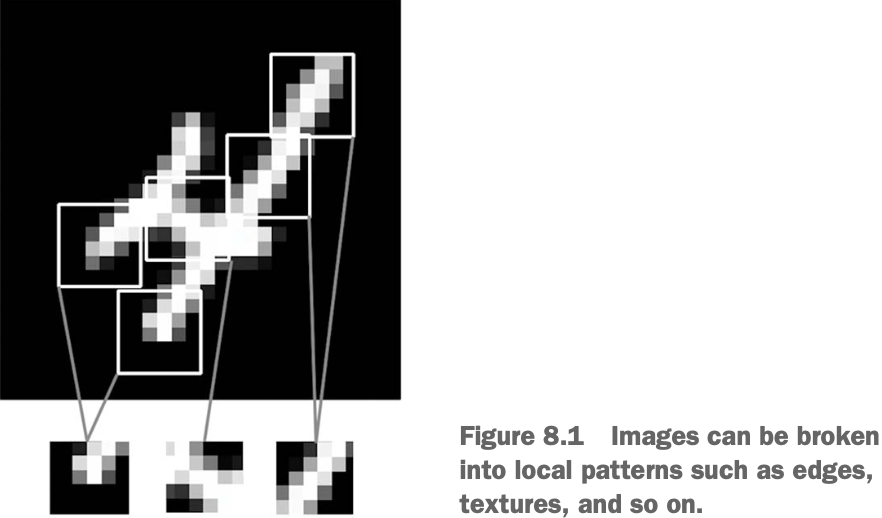

这个关键特征为convnets提供了两个有趣的属性：

- *The patterns they learn are translation-invariant.* 在图片右下角学习特定模式后，convnet可以在任何地方识别它：例如，在左上角。如果一个Dense连接的模型出现在新位置，则必须重新学习模式。这使得convnets在处理图像时具有数据效率（因为视觉世界基本上是平移不变的）：他们需要更少的训练样本来学习具有泛化能力的表示。
- *They can learn spatial hierarchies of patterns.* 第一个卷积层将学习边缘等小局部模式，第二个卷积层将学习由第一层特征组成的更大模式，以此类推（见图8.2）。这允许convnets有效地学习越来越复杂和抽象的视觉概念，因为视觉世界基本上是空间层次的。

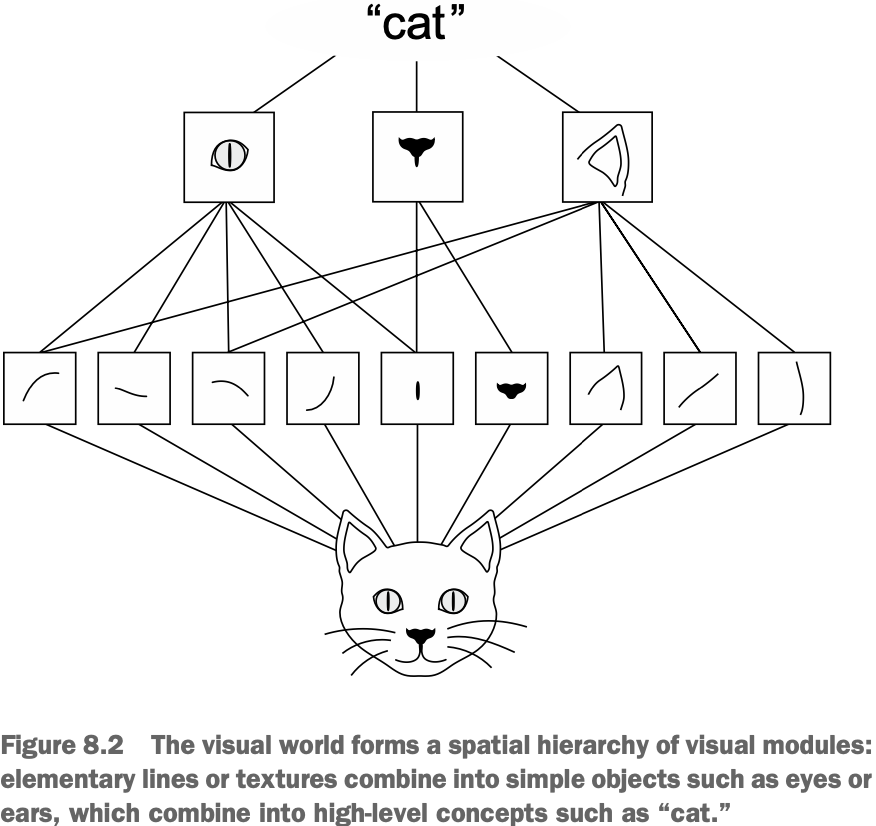

卷积在称为特征映射的 rank-3 张量上运行，具有两个空间轴（高度和宽度）和一个深度轴（也称为通道轴）。对于RGB图像，深度轴的尺寸为3，因为图像有三个颜色：红色、绿色和蓝色。对于黑白图片，如MNIST数字，深度为1（灰色级别）。卷积操作从其输入特征图中提取 patch，并对所有这些 patch 应用相同的转换，生成输出特征映射。此输出特征映射仍然是rank-3张量。 它的深度可以是任意的，因为输出深度是层的参数，该深度轴上的不同通道不再像RGB输入那样代表特定颜色；相反，它们代表 `filter`。 `filter` 编码输入数据的特定方面：例如，在高层上，单个 `filter` 可以编码“输入中存在人脸”的概念。

在MNIST示例中，第一个卷积层输入尺寸为 (28、28、1) 特征图，并输出大小为(26、26、32) 的特征图：它在输入上计算32个 filter。这32个输出通道中的每个都包含一个26×26的 `response grid`，这是 filter 在输入上的响应映射，指示该 filter 模式在输入不同位置的响应（见图8.3）。

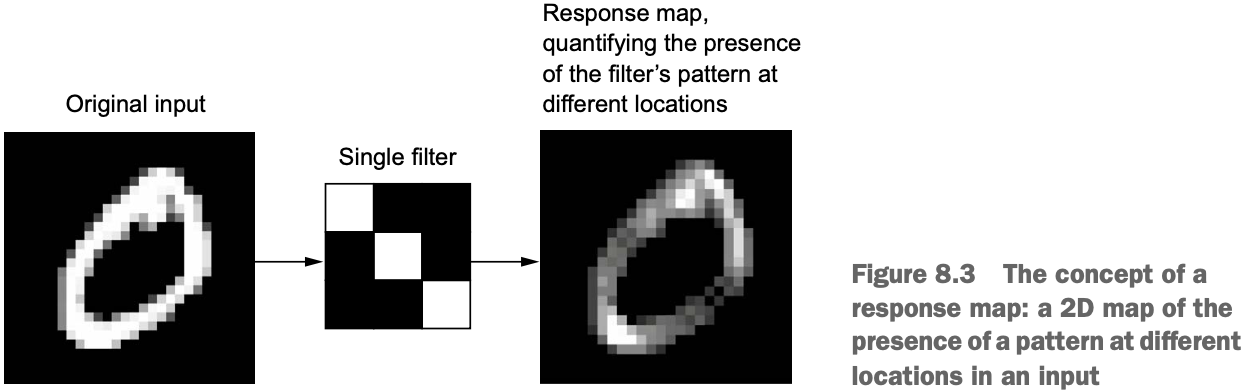

这就是特征映射的含义：深度轴中的每个维度都是特征（或filter），rank-2的张量输出 `[:, :, n]` 是该 filter 对输入响应的二维空间映射。

卷积由两个关键参数定义：

- **Size of the patches extracted from the inputs** —— 这些通常是3×3或5×5。在这个例子中，它们是3×3，这是一个常见的选择。
- **Depth of the output feature map** —— 这是由卷积计算的 filter 数量。该示例以32的深度开始，以64的深度结束。

在Keras Conv2D层中，这些参数是传递给该层的第一个参数：`Conv2D(output_depth，(window_height，window_width))`。

卷积的工作原理是将这些大小为 3×3 或 5×5 的窗口滑动到3D输入特征图上，在每个可能的位置停下来，并提取周围特征的3D patch (shape *(window_height，window_width，input_depth)*)。  然后，每个这样的 3D patch 被转换为形状的1D向量（ `output_depth` ），该向量通过具有学习权重矩阵（称为卷积核）的张量积完成——相同的卷积核在每个 patch 中重复使用。然后，所有这些矢量（每个 patch 一个）在空间上重新组装成形状的3D输出映射（*height, width, output_ depth*）。 输出特征图中的每个空间位置对应于输入特征图中的相同位置（例如，输出的右下角包含有关输入右下角的信息）。例如， `3 x 3` 的窗口， 向量 `output[i, j, :]` 来自于 3D patch `input[i-1:i+1, j-1:j+1, :]`。 完整的过程见图 8.4。

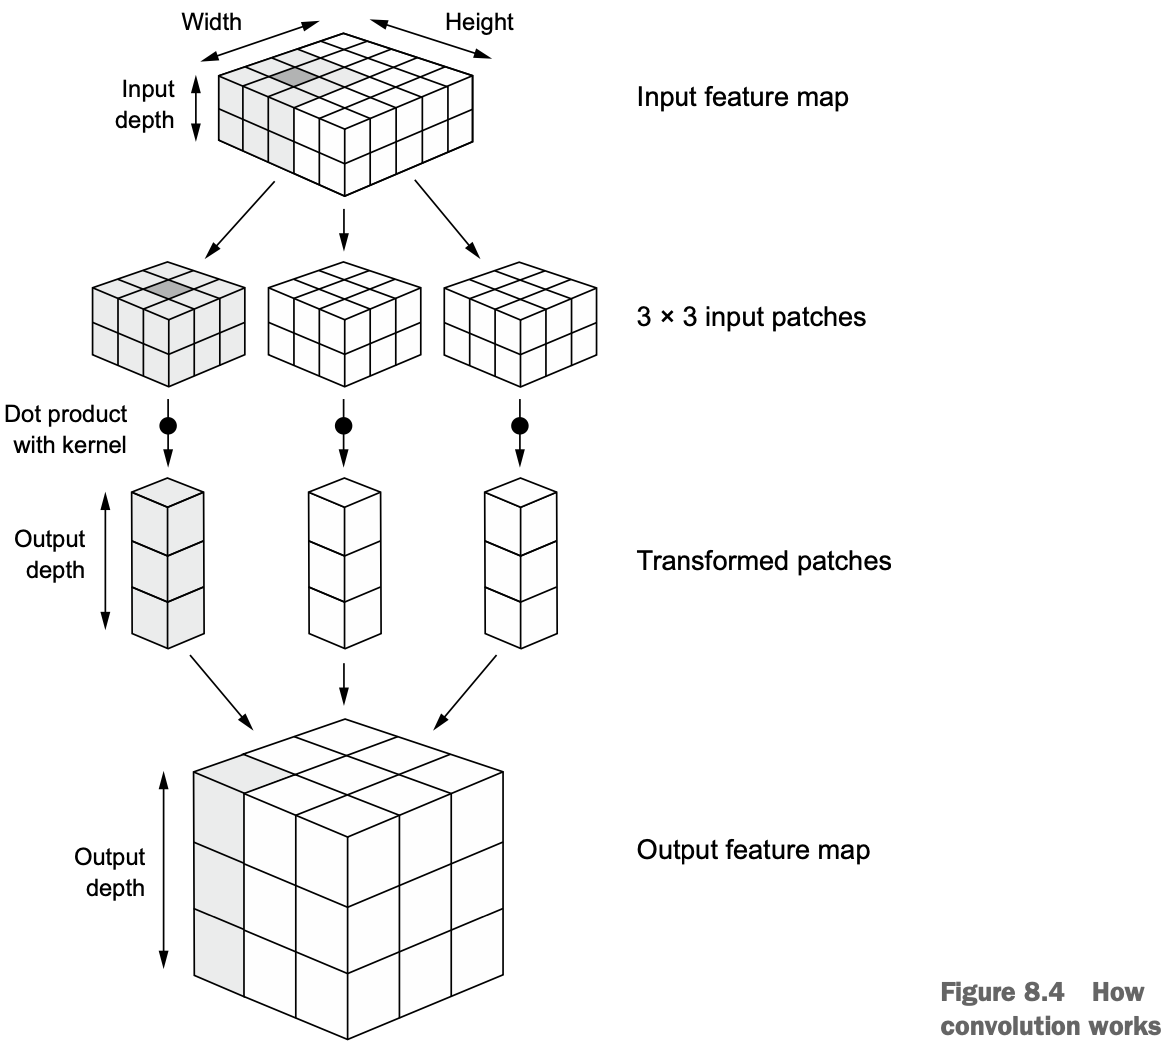

请注意，输出宽度和高度可能与输入宽度和高度不同，原因有二：

- 边界效果，可以通过填充输入特征图来抵消
- `strides` 的使用，我将在随后定义

### 8.1.2 The max-pooling operation

在convnet示例中，您可能已经注意到，在每个 MaxPooling2D 层之后，特征映射的大小都减少了一半。例如，在第一个 MaxPooling2D layers 之前，特征图是26×26，但最大池操作将其减半到13×13。这就是最大池化的作用：下采样特征映射，就像带步长的卷积一样。

最大池包括从输入特征映射中提取窗口并输出每个通道的最大值。它在概念上类似于卷积，只是它们不是通过学习的线性变换（卷积核）转换局部 patch，而是通过硬编码的取张量的最大值运算转换的。与卷积的一大区别是，最大池化通常使用2×2窗口和步长2来完成，以便用2的factor对特征映射进行下采样。另一方面，卷积通常用3×3个窗口完成，没有步长（stride 1）。

为什么下采样特征映射会这样？为什么不删除最大池层，并一直保持相当大的特征图呢？让我们看看这个选项。然后，我们的模型将看起来像以下列表。

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                619530    
Total params: 712,202
Trainable params: 712,202
Non-trainable params: 0
_____________________________________________________

此设置有什么问题？有两件事：

- 这不利于学习特征的空间层次结构。第三层中的3×3窗口将仅包含来自初始输入中7×7窗口的信息。在初始输入方面，convnet学到的高级模式仍然非常小，这可能不足以学习分类数字（尝试仅通过7×7像素的窗口查看数字！）。我们需要最后一个卷积层的特征来包含有关输入总量的信息。
- 最终特征图每个样本的总系数为22×22×128=61,952。这是巨大的。当您将其 flatten 使用 Dense 层 10 分类时，该层将有超过50万个参数。对于这么小的模型来说，这太大了，会导致严重的过拟合。

简而言之，使用下采样的原因是减少要处理的特征映射系数的数量，以及通过让连续的卷积层查看越来越大的窗口（就它们覆盖的原始输入的比例而言）来诱导空间 filter 层次结构。

请注意，最大池化并不是实现此类下采样的唯一方法。如您所知，您还可以在之前的卷积层中使用步幅。您可以使用平均池化而不是最大池化，其中每个局部输入 patch 都是通过在 patch 上取每个通道的平均值而不是最大值来跨形成的。但最大池化往往比这些替代解决方案更有效。理由是，特征倾向于在特征图的不同 tile 上编码某些模式或概念（因此称为特征映射），并且查看不同特征的最大存在比查看其平均存在的信息更丰富。最合理的子采样策略是首先生成密集的特征映射（通过 unstrided convolutions），然后查看特征在小 patch 上的最大激活，而不是查看输入的稀疏窗口（通过 stride convolutions）或平均输入 patch，这可能会导致您错过或稀释特征信息。

此时，您应该了解convnets的基础知识——特征映射、convolution和max pooling——并且您应该知道如何构建小型convnet来解决MNIST数字分类等玩具问题。现在，让我们来谈谈更有用、更实用的应用程序。

## 8.2 Training a convnet from scratch on a small dataset

不得不使用很少的数据训练图像分类模型是一种常见的位置，如果您在专业环境中进行计算机视觉，您在实践中可能会遇到这种情况。“少数”样本可能意味着从几百到几万张图像不等。作为一个实际例子，我们将专注于在包含5000张猫和狗图片（2500只猫，2500只狗）的数据集中将图像归类为狗或猫。我们将使用2000张图片进行训练，1000张用于验证，2000张用于测试。

在本节中，我们将回顾一个解决这个问题的基本策略：使用您拥有的少量数据从头开始训练新模型。我们将从在2000个训练样本上训练一个小convnet开始，不用任何正则化，为可以实现的目标设定基线。这将使我们的分类准确率达到约70%。到那时，主要问题将是过拟合。然后，我们将介绍数据增强，这是一种减轻计算机视觉过拟合的强大技术。通过使用数据增强，我们将改进模型，达到80-85%的准确性。

在下一节中，我们将回顾将深度学习应用于小型数据集的另外两种基本技术：使用预训练模型进行特征提取（这将使我们的准确率达到97.5%）和微调预训练模型（这将使我们最终达到98.5%的准确率）。这三种策略结合在一起——从头开始训练一个小模型，使用预先训练的模型进行特征提取，以及在预训练模型上进行微调 —— 将构成您未来解决执行使用小数据集进行图像分类问题的工具箱。

### 8.2.1 The relevance of deep learning for small-data problems

首先，训练模型的“足够样本”是相对的 —— 相比于您试图训练的模型的大小和深度。仅仅用几十个样本就不可能训练convnet来解决一个复杂的问题，但如果模型很小，规范性很好，任务很简单，几百个就足够了。由于convnets学习平移不变特征，因此它们在感知问题上的数据效率很高。尽管相对缺乏数据，但在非常小的图像数据集上从头开始训练convnet将产生合理的结果，而无需任何自定义特征工程。您将在本节中看到此操作。

此外，深度学习模型本质上具有高度可利用性：例如，您可以在大型数据集上训练的图像分类或语音到文本模型，并在一个明显不同的问题上重用，只需稍作微的更改。特别地，就计算机视觉而言，许多预训练的模型（通常在ImageNet数据集上训练）现在可以公开下载，并可用于从很少的数据中启动强大的视觉模型。这是深度学习的最大优势之一：特征重用。您将在下一节中探索这一点。

我们先来了解数据，我们先来了解一下数据。

## 8.2.2 Downloading the data

我们将使用的 狗vs猫 数据集没有与Keras一起打包。2013年底，当convnets不是主流时，Kaggle在计算机视觉竞赛中提供了它。您可以从 [www.kaggle.com/c/dogs-vs-cats/data](www.kaggle.com/c/dogs-vs-cats/data) 下载原始数据集（如果您还没有Kaggle帐户，则需要创建一个Kaggle帐户——别担心，这个过程是无痛的）。您还可以使用 Kaggle API 在 Colab 中下载数据集（请参阅“在Google Colaboratory中下载Kaggle数据集”边栏）

> **Downloading a Kaggle dataset in Google Colaboratory**
> 
> Kaggle提供了易于使用的API，以编程方式下载 Kaggle 托管的数据集。你可以用它来下载 Dogs vs. Cats 的数据集到Colab笔记本。此 API 作为 kaggle 软件包可用，该软件包在Colab上已预安装。下载此数据集就像在Colab单元格中运行以下command一样简单：
>```
>!kaggle competitions download -c dogs-vs-cats
> ```
> 
> 但是，对 API 的访问仅限于 Kaggle 用户，因此为了运行预割让命令，您首先需要对自己进行身份验证。kaggle软件包将在位于 `~/.kaggle/kaggle.json` 的JSON文件中查找您的登录凭据。让我们创建这个文件。
>
> 首先，您需要创建一个 Kaggle API 密钥并将其下载到本地计算机。只需在网页浏览器中导航到 Kaggle 网站，登录并转到我的帐户页面。在您的帐户设置中，您将找到一个 API 部分。单击创建新 API token 按钮将生成一个kaggle.json 密钥文件，并将其下载到您的机器上。
>
> 其次，转到您的Colab notebook，并通过在 notebook 单元格中运行以下代码将API的关键JSON文件上传到您的Colab会话：
> 
> ```python
> from google.colab import files 
> files.upload()
> ```
> 
> 当您运行此单元格时，您将看到一个选择文件按钮。单击它，然后选择您刚刚下载的kaggle.json文件。这会将文件上传到本地Colab runtime。
> 
> 最后， 创建一个 `~/.kaggle` 文件夹 (`mkdir~/.kaggle`), 并将密钥文件复制到它 (`cpkaggle.json~/.kaggle/`)。 作为安全最佳实践，您还应该确保文件只能由当前用户自己读取（ `chmod600`）：
> 
> ```
> !mkdir ~/.kaggle
> !cp kaggle.json ~/.kaggle/
> !chmod 600 ~/.kaggle/kaggle.json
> ```
> 
> 您现在可以下载我们即将使用的数据：
>
> ```
> !kaggle competitions download -c dogs-vs-cats
> ```
>
> 第一次尝试下载数据时，您可能会收到“403禁止”错误。这是因为在下载数据集之前，您需要接受与数据集相关的条款——您必须转到 [www.kaggle.com/c/dogs-vs-cats/rules](www.kaggle.com/c/dogs-vs-cats/rules) （登录您的Kaggle帐户时），然后单击“我理解和接受”按钮。你只需要这样做一次。
> 
> 最后，训练数据是一个名为train.zip的压缩文件。确保您默默(`-qq`)解压缩（`unzip`）：
> 
> ```
> !unzip -qq train.zip
> ```



我们数据集中的图片是中等分辨率 彩色JPEG。图8.8显示了一些例子。

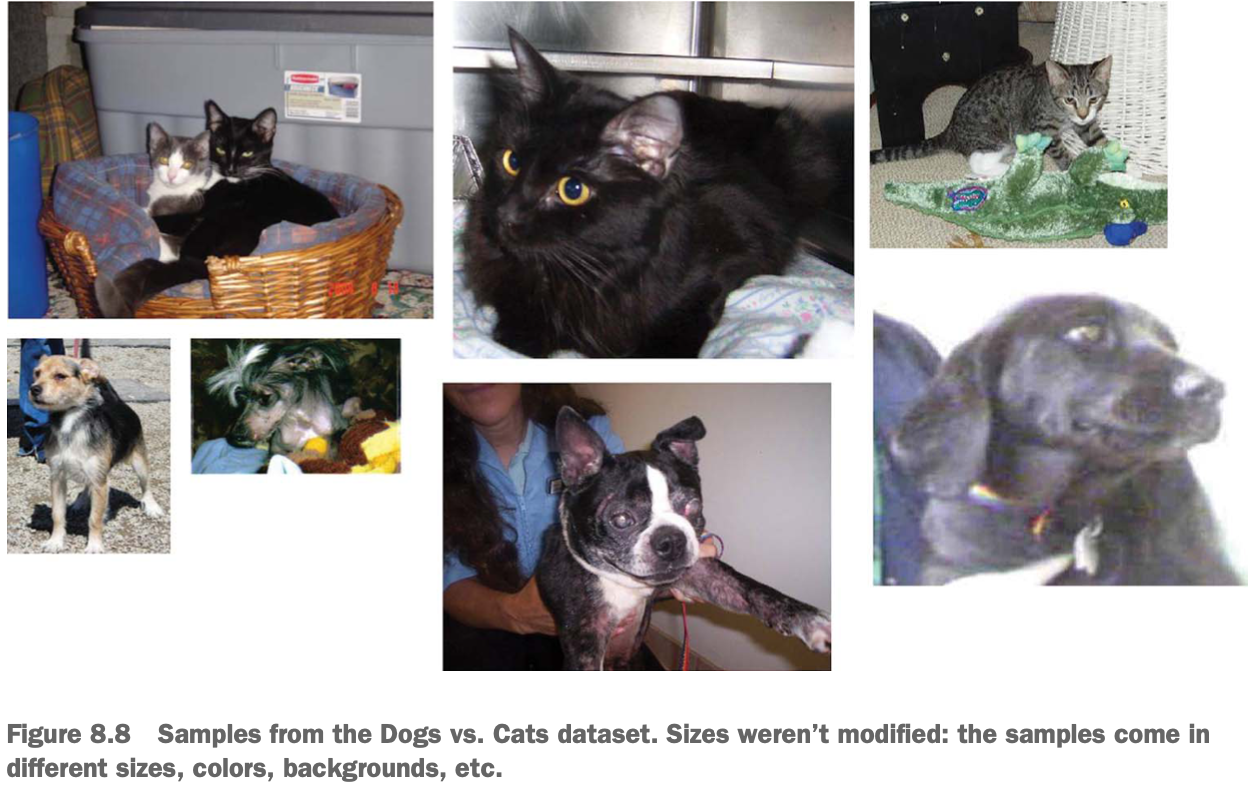

毫不奇怪，最初的  dogs-versus-cats Kaggle 比赛早在2013年就由使用convnet的参赛者获胜。最佳准确率高达95%。在本例中，我们将相当接近这种准确性（在下一节中），即使我们将根据竞争对手可用的不到10%的数据来训练我们的模型。

该数据集包含25,000张狗和猫的图像（每个类别12,500张），为543 MB（压缩）。下载和解压缩数据后，我们将创建一个包含三个子集的新数据集：每个类有1000个样本的训练集，每个类有500个样本的验证集，以及每个类有1000个样本的测试集。 为什么要这样做？因为您在职业生涯中遇到的许多图像数据集只包含几千个样本，而不是数万个样本。拥有更多可用数据将使问题更容易，因此使用小数据集学习是良好做法。

我们将处理的子采样数据集将具有以下目录结构：

```
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("dogs-vs-cats/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index): 
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)] 
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)
            
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

我们现在有2000张训练图像、1000张验证图像和2000张测试图像。每个 split 包含每个类相同数量的样本：这是一个平衡的二分类问题，这意味着分类准确性将是衡量成功的适当标准。

### 8.2.3 Building the model

我们将重用您在第一个示例中看到的相同的通用模型结构：convnet将是一堆交替的Conv2D（具有relu激活）和MaxPooling2D 层。

但是，由于我们正在处理更大的图像和更复杂的问题，我们将相应地使我们的模型变大：它将有另外两个 Conv2D 和MaxPooling2D 。这既可以增加模型的容量，也可以进一步缩小特征图的大小，这样当我们到达 flatten 层时，它们就不会太大。在这里，由于我们从 180像素×180像素 的输入开始（有点任意的选择），我们最终会在 flatten 层之前获得尺寸为7×7的特征图。

**Note:** 模型中特征图的深度逐渐增加（从32到256），而特征图的大小减少（从180×180到7×7）。这是您在几乎所有的convnets中看到的模式。

由于我们正在研究二分类问题，我们将用单个单元（尺寸为1的 Dense 层）和 sigmoid 激活来结束模型。该单元将编码模型为查看一个或另一个类的概率。

最后一个小区别：我们将从 `Rescaling` 层开始模型，该层将图像输入（其值最初在 `[0,255]` 范围内）重新缩放到`[0, 1]` 范围。

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

让我们看看特征图的尺寸如何随着每个连续的层而变化：

In [12]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 128)       7385

对于编译步骤，我们将像往常一样使用 `RMSprop` 优化器。由于我们用单个 `sigmoid` 单元结束模型，我们将使用二分类交叉熵作为损失（谨此提醒，请查看第6章中的表6.1，以获取在各种情况下使用的损失函数）。

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 8.2.4 Data preprocessing

如您现在所知，在输入模型之前，数据应该格式化为预处理的浮点张量。目前，数据作为JPEG文件放置在驱动器上，因此将其放入模型的步骤大致如下：

- 读取图片文件。
- 将JPEG内容解码为RGB的像素网格。
- 将这些转换为浮点张量。
- 将它们的大小调整为相同大小（我们将使用180×180）。
- 把它们打包成批量（我们将使用32张图像的批次）。

这可能看起来有点令人生畏，但幸运的是，Keras有程序可以自动处理这些步骤。特别是，Keras 有函数`image_dataset_from_ directory()`，它允许您快速设置数据管道，该管道可以自动将磁盘上的映像文件转换为一批预处理的张量。这就是我们将在这里使用的内容。

调用 `image_dataset_from_directory(directory)` 将首先列出目录的子目录，并假设每个目录都包含我们其中一个类的图像。然后，它将为每个子目录中的图像文件编制索引。最后，它将创建并返回一个 `tf.data.Dataset` 对象，该对象配置为读取这些文件，打乱它们，将其解码为张量，将它们调整为相同大小，并将其打包成批次。


In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
            new_base_dir / "train",
            image_size=(180, 180),
            batch_size=32)

validation_dataset = image_dataset_from_directory(
            new_base_dir / "validation",
            image_size=(180, 180),
            batch_size=32)

test_dataset = image_dataset_from_directory(
            new_base_dir / "test",
            image_size=(180, 180),
            batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


> **Understanding TensorFlow `Dataset` objects**
> 
> TensorFlow 提供了 `tf.data` API，为机器学习模型创建高效的输入管道。它的核心类是 `tf.data.Dataset`。
>
> `Dataset` 对象是一个迭代器：您可以在 `for` 循环中使用它。它通常会返回成批的输入数据和标签。您可以将 `Dataset` 对象直接传递给 Keras 模型的 `fit()` 方法。
> 
> `Dataset` 类处理许多关键特性，否则实现自己会很麻烦——特别是异步数据预获取（在模型处理上一批数据时预处理下一批数据，这使执行不间断）。
> 
> `Dataset` 类还公开了一个用于修改数据集的 Functional-style API。这里有一个快速示例：让我们从随机数字的 NumPy 数组创建一个数据集实例。我们将考虑1000个样本，其中每个样本都是大小为16的矢量：
> 
> ```python
> import numpy as np
> import tensorflow as tf
> random_numbers = np.random.normal(size=(1000, 16))
> dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
> 
> 首先，我们的数据集只产生单个样本：

> ```python
> for i, element in enumerate(dataset):
>     print(element.shape)
>     if i >= 2:
>         break
(16,)
(16,)
(16,)
> ```
> 
> 我们可以使用 `.batch()` 方法来批处理数据：
> 
> ```python
> batched_dataset = dataset.batch(32)
> for i, element in enumerate(batched_dataset):\
>     print(element.shape)
>     if i >= 2:
>         break
(32, 16)
(32, 16)
(32, 16)
> ```
> 
> 更广泛地说，我们可以访问一系列有用的数据集方法，例如
> 
> - `.shuffle(buffer_size)` —— 在缓冲区中洗牌元素
> - `.prefetch(buffer_size)` —— 在GPU内存中预取元素缓冲区， 实现更好的设备利用率。
> - `- .map(callable)` —— 对数据集每个元素应用任意 transformation（可调用的函数，期望将数据集生成的单个元素作为输入）。
> 
> 特别是 `.map()` 方法，您将经常使用这种方法。这里有一个例子。我们将使用它来 reshape 数据集中的元素，从形状（16）到形状（4，4）：
>
> ```python
> reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
> for i, element in enumerate(reshaped_dataset):
>     print(element.shape)
>     if i >= 2:
>         break
> (4, 4)
(4, 4)
(4, 4)
> 
> 您即将在本章中看到更多 `map()` 操作。

让我们看看这些数据集对象之一的输出：它产生成批180×180 RGB图像(shape(32，180，180，3))和整数标签(shape(32，))。每批有32个样本(批次大小)。


In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


让我们在数据集上设置模型。我们将使用 `fit()` 中的 `validation_data` 参数来监控单独 `Dataset` 对象上的验证指标。

请注意，我们还将使用 `ModelCheckpoint` 回调在每个 epoch 后保存模型。 我们将使用指定保存文件位置的路径以及参数 `save_best_only=True` 和 `monitor="val_loss"`进行配置：当 `val_loss` 指标的当前值低于训练期间时，它们告诉回调仅保存新文件（覆盖以前的文件）。这保证了您保存的文件将始终包含与其最佳训练 epoch 相对应的模型状态，即其在验证数据上的性能。因此，如果我们开始过拟合，我们将不必为更少的 epoch 重新训练新模型：我们只需重新加载保存的文件。

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
            train_dataset,
            epochs=30,
            validation_data=validation_dataset,
            callbacks=callbacks)

Epoch 1/30


2022-04-06 13:23:49.876335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.5155

2022-04-06 13:23:59.872190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 12s 157ms/step - loss: 0.7507 - accuracy: 0.5155 - val_loss: 0.6919 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 10s 155ms/step - loss: 0.7146 - accuracy: 0.5500 - val_loss: 0.6864 - val_accuracy: 0.5570
Epoch 3/30
63/63 [==============================] - 10s 160ms/step - loss: 0.6814 - accuracy: 0.5885 - val_loss: 0.6828 - val_accuracy: 0.5760
Epoch 4/30
63/63 [==============================] - 11s 166ms/step - loss: 0.6607 - accuracy: 0.6330 - val_loss: 0.6431 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 11s 177ms/step - loss: 0.6029 - accuracy: 0.6850 - val_loss: 0.6687 - val_accuracy: 0.6300
Epoch 6/30
63/63 [==============================] - 10s 160ms/step - loss: 0.5649 - accuracy: 0.7055 - val_loss: 0.5780 - val_accuracy: 0.7060
Epoch 7/30
63/63 [==============================] - 10s 155ms/step - loss: 0.5257 - accuracy: 0.7415 - val_loss: 0.5696 - val_accuracy: 0.7250
Epoch 8/30

让我们在训练期间对训练和验证数据绘制模型的损失和准确性（见图8.9）。

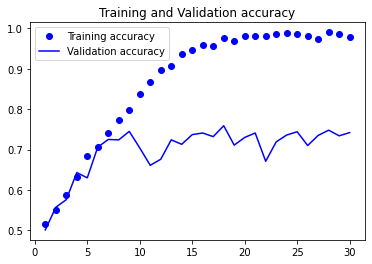

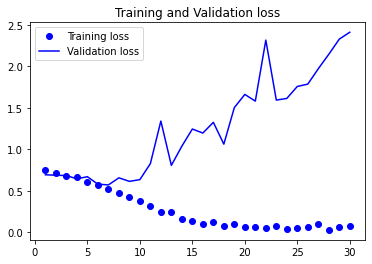

In [19]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

这些 plot 具有过拟合的特点。训练精度随着时间的推移呈线性增长，直到达到近100%，而验证精度达到75%。验证损失仅在十个 epoch 后就达到最低水平，然后停滞不前，而训练损失则随着训练的进行而线性下降。

让我们检查一下测试的准确性。我们将从其保存的文件中重新加载模型，以在开始过拟合之前评估它。

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

2022-04-06 13:41:42.361520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 44ms/step - loss: 0.5563 - accuracy: 0.7185
Test accuracy: 0.719


我们的测试准确率为69.5%。（由于神经网络初始化的随机性，误差可能会在其中一个百分点内。） 

由于我们的训练样本相对较少（2,000个），过拟合将是我们最关心的问题。您已经知道一些可以帮助缓解过拟合的技术，例如 `dropout` 和 `weight decay(L2正则化)`。我们现在将使用一种新的，专门针对计算机视觉，并在处理具有深度学习模型的图像时几乎普遍使用：数据增强。

### 8.2.5 Using data augmentation

过拟合是由于样本太少而导致您无法训练可以推广到新数据的模型。给定无限数据，您的模型将暴露在手头数据每个可能的分布：您永远不会过拟合。数据增强采用从现有训练样本中生成更多训练数据的方法，通过一些随机转换来增加样本，从而产生可信的图像。目标是，在训练时间，您的模型永远不会两次看到完全相同的图片。这有助于将模型暴露在数据的更大分布中，以便更好地泛化。

在Keras中，这可以通过在模型开始时添加一些 `data augmentation` 层来实现。让我们从一个例子开始：以下顺序模型链接几个随机图像转换。在我们的模型中，我们会将其包含在 `Rescaling` 层之前。

In [35]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
                [
                    # layers.RandomFlip("horizontal"),
                    layers.RandomRotation(0.1),
                    # layers.RandomZoom(0.2),
    ] )

这些只是可用的几个层（有关更多，请参阅Keras文档）。让我们快速浏览一下这个代码：

- `RandomFlip("horizontal")` —— 将水平翻转应用于经过它的50%的随机图像
- `RandomRotation(0.1)` —— 在 `[–10%，+10%]` 范围内通过随机值旋转输入图像(以度为单位，范围为 `[–36度，+36度]`）
- `RandomZoom(0.2)` —— 通过一个随机因子放大或缩小图像范围 `[-20%，+20%]`。

我们来看看增强后的图像(见图 8.10)

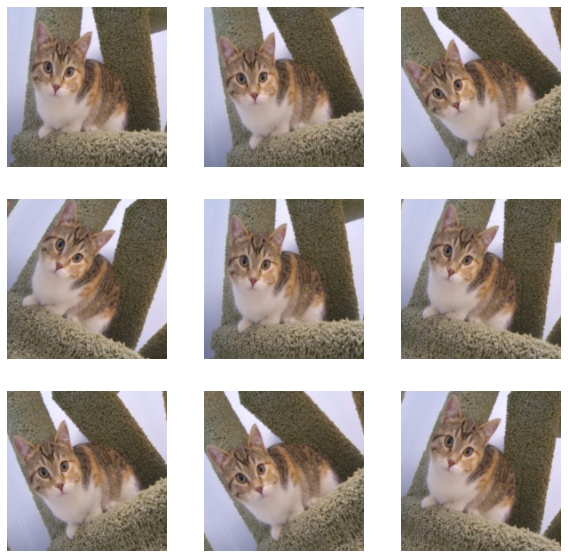

In [36]:
import tensorflow as tf
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1) 
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

如果我们使用此数据增强配置训练新模型，该模型将永远不会两次看到相同的输入。但是输入仍然具有强相关性因为他来自原始图像 —— 我们不能产生新的信息。 我们只能重新混合现有信息。因此，这可能不足以完全摆脱过拟合。为了进一步对抗过拟合，我们还将在 Dense 连接的分类器之前在模型中添加一个 `Dropout` 层。

关于随机图像增强层，你应该知道的最后一件事：就像 `Dropout` 一样，它们在推理期间不激活（当我们调用 `predict()` 或 `evaluate()` 时）。在评估期间，我们的模型的行为将与不包括数据增强和 `Dropout` 时完全相同。

In [38]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

让我们使用数据增强和 `Dropout` 来训练模型。由于我们预计在训练期间会晚得多发生过拟合，我们将训练三倍的 epoch —— 一百个。

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/100


2022-04-06 14:14:18.377458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.4985

2022-04-06 14:14:28.164552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 12s 169ms/step - loss: 0.8206 - accuracy: 0.4985 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 11s 169ms/step - loss: 0.6964 - accuracy: 0.5265 - val_loss: 0.6889 - val_accuracy: 0.5010
Epoch 3/100
63/63 [==============================] - 11s 167ms/step - loss: 0.6925 - accuracy: 0.5595 - val_loss: 0.6694 - val_accuracy: 0.6140
Epoch 4/100
63/63 [==============================] - 10s 164ms/step - loss: 0.6770 - accuracy: 0.6040 - val_loss: 0.6725 - val_accuracy: 0.5470
Epoch 5/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6706 - accuracy: 0.6265 - val_loss: 0.6860 - val_accuracy: 0.5700
Epoch 6/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6398 - accuracy: 0.6600 - val_loss: 0.6093 - val_accuracy: 0.6670
Epoch 7/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6134 - accuracy: 0.6750 - val_loss: 0.6809 - val_accuracy: 0.6090
Epoc

让我们再次绘制结果：见图8.11。由于数据增强和 `Dropout`，我们很晚才开始过拟合，大约在60-70 epoch。 验证准确性最终始终保持在80-85%的范围内——比我们第一次尝试有了很大的改进。

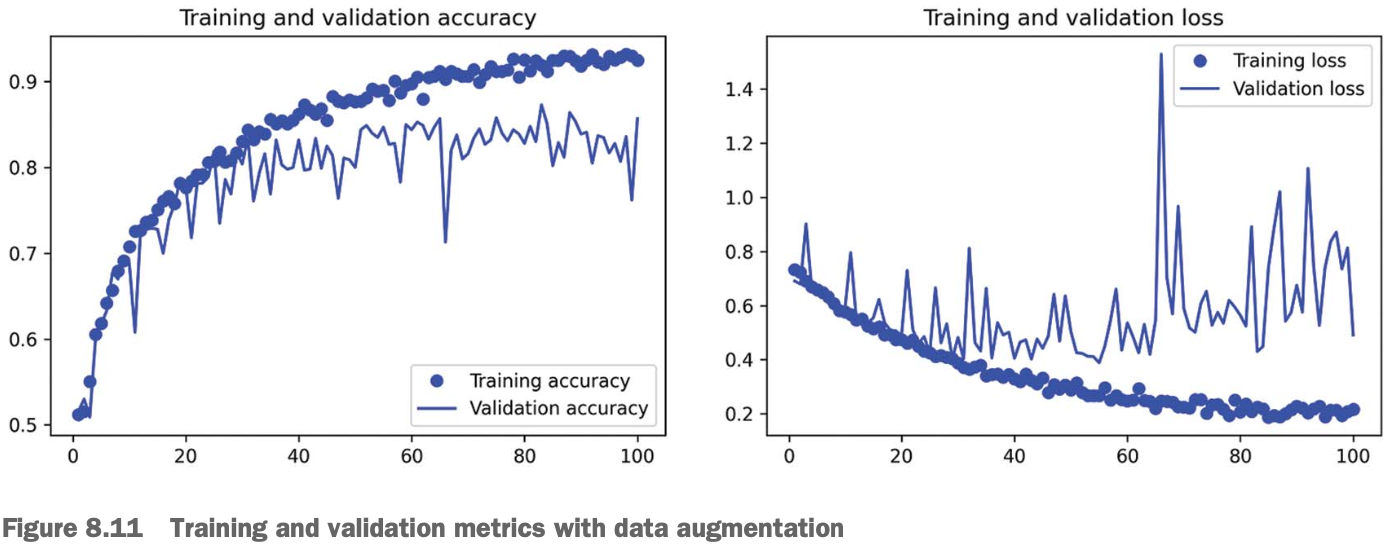

In [40]:
test_model = keras.models.load_model(
            "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

2022-04-06 14:32:46.807590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 46ms/step - loss: 0.5663 - accuracy: 0.7765
Test accuracy: 0.777


我们的测试准确率为77.7%。它开始看起来不错了！如果您使用的是Colab，请确保下载保存的文件（convnet_from_scratch_with_augmentation.keras），因为我们将在下一章中将其用于一些实验。

通过进一步调整模型的配置（例如每个卷积层的 filter 数量或模型中的层数），我们也许能够获得更好的精度，可能高达90%。但事实证明，仅仅从零开始训练我们自己的convnet就很难走得更高，因为我们几乎没有数据可以处理。作为提高我们在这个问题上的准确性的下一步，我们必须使用经过预训练的模型，这是接下来两个部分的重点。

## 8.3 Leveraging a pretrained model

在小型图像数据集上进行深度学习的一个常见且高效的方法是使用预训练的模型。预训练模型是以前在大型数据集上训练的模型，通常是大规模图像分类任务。如果这个原始数据集足够大和通用，则预训练模型学习的特征的空间层次结构可以有效地充当视觉世界的通用模型，因此，其特征可以证明对许多不同的计算机视觉问题有用，即使这些新问题可能涉及与原始任务完全不同的类别。例如，您可能会在ImageNet上训练模型, 然后将这个训练好的模型重新用识别图像中的家具物品。这种跨越不同问题的学习特征的可移植性是深度学习与许多旧的浅层学习方法相比的关键优势，它使深度学习对小数据问题非常有效。

在这种情况下，让我们考虑一个在ImageNet数据集上训练的大型convnet（140万张标记图像和1000个不同类别）。ImageNet包含许多动物类别，包括不同种类的猫和狗，因此您可以期望它在狗对猫分类问题上表现良好。

我们将使用 Karen Simonyan 和 Andrew Zisserman 在2014年开发的VGG16架构。虽然它是一个较旧的模型，远非目前的SOTA，比许多其他最近的网络更大，但我选择它是因为它的架构与你已经熟悉的相似，并且很容易理解，无需引入任何新概念。这可能是您第一次遇到这些可爱的型号名称之一——VGG、ResNet、Inception、Xception等；您将习惯它们，因为如果您继续为计算机视觉进行深度学习，它们会经常出现。

使用预训练模型有两种方法：特征提取和微调。我们将涵盖他们两个。让我们从特征提取开始。

### 8.3.1 Feature extraction with a pretrained model

特征提取包括使用之前训练过的模型学到的表示，从新样本中提取有趣的特征。然后，这些功能通过一个新的分类器运行，该分类器从头开始训练。

如前所述，用于图像分类的convnet由两部分组成：它们从一系列池化层和卷积层开始，以 Dense连接 的分类器结束。第一部分被称为模型的卷积基础。就convnet而言，特征提取包括获取预训练网络的 `convolutional base`，通过它运行新数据，并在输出之上训练一个新的分类器(见图8.12)。

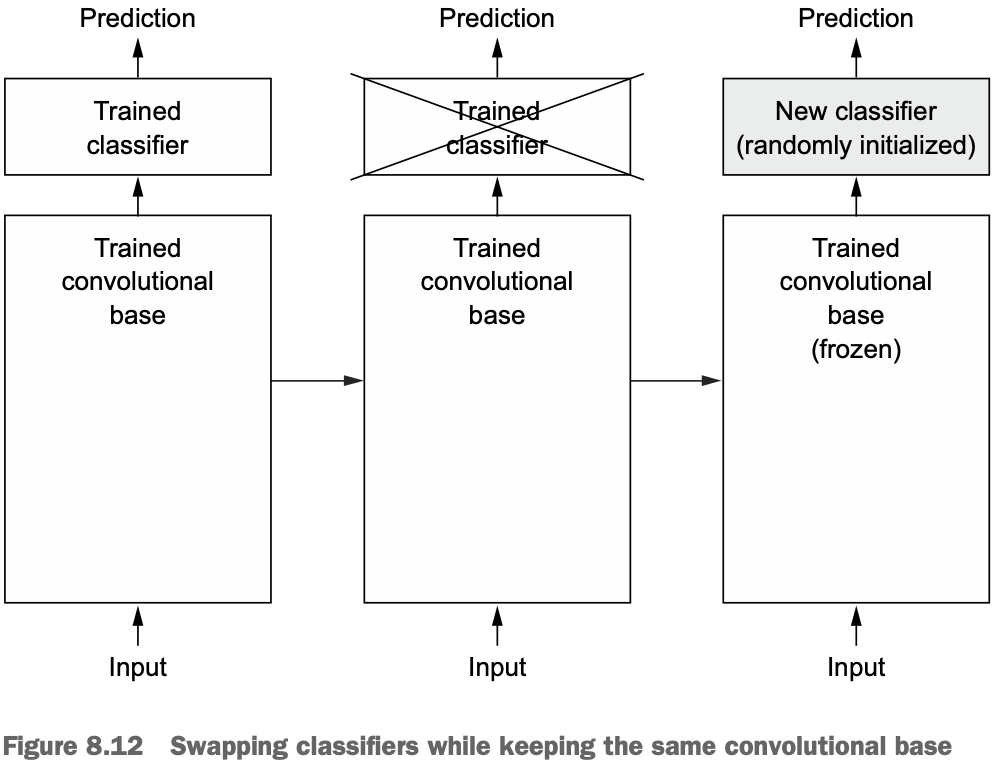

为什么只重用 `convolutional base`？我们也可以重用 Dense连接 的分类器吗？一般来说，应该避免这样做。原因是，`convolutional base` 学到的响应可能更通用，因此更可重用：convnet的特征映射是图片上通用概念的存在映射，无论手头的计算机视觉问题如何，它们都可能有用。但分类器学到的表示形式必然特定于训练模型的类集——它们只会包含有关整个图像中该类存在概率的信息。此外， 在全连接层的表征不再包含任何的输入图像的目标信息。这些层摆脱了空间的概念，而物体位置仍然由卷积特征图描述。 对于目标位置很重要的问题，全连接的特征在很大程度上毫无用处。

请注意，由特定卷积层提取的表示的通用性（因此也是可重用性）水平取决于模型中层的深度。模型中较早的层提取局部高度通用的特征图（如视觉边缘、颜色和纹理），而较高的图层提取更抽象的概念（如“猫耳朵”或“狗眼”）。因此，如果您的新数据集与训练原始模型的数据集有很大不同，您可能会只使用模型的前几层进行特征提取，而不是使用整个 `convolutional base`。

在这种情况下，由于ImageNet类集包含多个狗和猫类，因此重用原始模型全连接层中包含的信息可能是有益的。但我们会选择不这样做，以涵盖新问题的类集与原始模型的类集不重叠的更一般的情况。让我们通过使用在ImageNet上训练的VGG16网络的 `convolutional base` 将其付诸实践，从猫和狗图像中提取有趣的特征，然后在这些特征的基础上训练狗对猫的分类器。

VGG16模型与Keras封装的其他模型可以从 `keras.applications` 模块导入它。许多其他图像分类模型（均在ImageNet数据集上预训练）作为 `keras.applications` 的一部分可用：

- Xception
- ResNet
- MobileNet 
- EfficientNet 
- DenseNet
- etc.

让我们实例化 VGG16 模型。

In [43]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

我们将三个参数传递给构造函数：

- `weights` 指定初始化模型的权重 checkpoint。
- `include_top` 是否包含网络顶部的全连接分类器。 
- `input_shape` 是我们将提供给网络的图像张量的形状。这个参数是可选的：如果我们不传递它，网络将能够处理任何大小的输入。在这里，我们传递它，以便（在后续 summary 中）可视化特征映射的大小如何随着每个新的卷积层和池化层而缩小。

以下是VGG16 `convolutional base` 架构的细节。它类似于您已经熟悉的简单convnet：

In [44]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

最终的特征图形状为(5，5，512)。这是功能图，我们将在上面加一个全连接的分类器。

这里我们有两种方法可以继续：
- 在我们的数据集上运行 `convolutional base`，将其输出记录到磁盘上的NumPy数组，然后使用这些数据作为独立、全连接的分类器的输入，类似于您在本书第4章中看到的。这个解决方案运行起来又快又便宜，因为它只需要为每个输入图像运行一次 `convolutional base`，而 `convolutional base` 是迄今为止管道中最昂贵的部分。但出于同样的原因，这种技术不允许我们使用数据增强。
- 通过在顶部添加全连接层来扩展我们的模型（conv_base），并在输入数据上从头到尾运行整个过程。这将允许我们使用数据增强，因为每个输入图像每次被模型看到时都会通过 `convolutional base`。但出于同样的原因，这种技术比第一种要昂贵得多。

我们将介绍这两种技术。让我们浏览一下设置第一个代码所需的代码：在我们的数据上记录conv_base的输出，并使用这些输出作为新模型的输入。

**FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION**

我们首先实现提取NumPy数组的函数，在我们的训练、验证和测试数据集上调用 `conv_base` 模型的 `predict()` 方法。

让我们迭代我们的数据集来提取 VGG16 特征。

In [46]:
import numpy as np
def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) 
        features = conv_base.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset) 
val_features, val_labels = get_features_and_labels(validation_dataset) 
test_features, test_labels = get_features_and_labels(test_dataset)

2022-04-06 18:05:07.888500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-06 18:05:33.758047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


重要的是，`predict()`只期望图像，而不要标签，但我们当前的数据集生成包含图像及其标签的批次。此外，VGG16模型希望使用 `keras.applications.vgg16.preprocess_input` 函数预处理输入，该函数将像素值缩放到适当的范围。

提取的特征形状为 `(sample，5,5,512)`：

In [47]:
train_features.shape

(2000, 5, 5, 512)

此时，我们可以定义我们的全连接分类器（注意使用 `Dropout` 进行正则化），并在我们刚刚记录的数据和标签上对其进行训练。

In [48]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20


2022-04-06 18:08:34.497055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 17.5116 - accuracy: 0.9230

2022-04-06 18:08:35.604249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 17ms/step - loss: 17.5116 - accuracy: 0.9230 - val_loss: 31.8928 - val_accuracy: 0.8630
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 3.7330 - accuracy: 0.9705 - val_loss: 5.2328 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 1s 12ms/step - loss: 1.8589 - accuracy: 0.9840 - val_loss: 5.7879 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 1s 13ms/step - loss: 2.2155 - accuracy: 0.9890 - val_loss: 5.3500 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 1s 13ms/step - loss: 0.6734 - accuracy: 0.9940 - val_loss: 4.4576 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.7198 - accuracy: 0.9935 - val_loss: 4.5581 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.6308 - accuracy: 0.9920 - val_loss: 5.3166 - val_accuracy: 0.9690
Epoch 8/20
63/63 [====

训练非常快，因为我们只需要处理两个 Dense 层 —— 即使在CPU上，一个 epoch 也只需要不到一秒钟。

让我们看看训练期间的损失和准确性曲线。

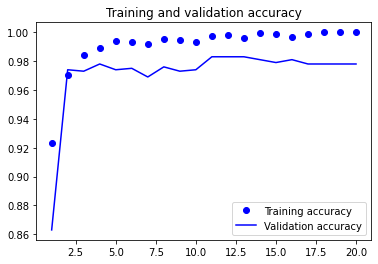

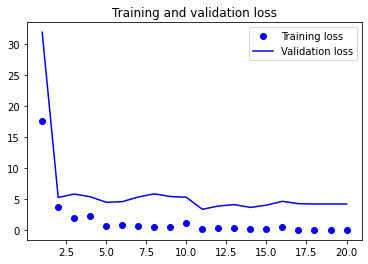

In [51]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy") 
plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


我们达到了约97%的验证精度 —— 比上一节从头开始训练的小模型要好得多。然而，这是一个有点不公平的比较，因为ImageNet包含许多狗和猫实例，这意味着我们预训练的模型已经拥有手头任务所需的确切知识。当您使用预训练的特征时，情况并非总是如此。

然而，这些 plot 也表明，尽管我们使用 `Dropout` 相当高，但我们从一开始就已经过拟合了。这是因为这项技术不使用数据增强，这对于防止与小图像数据集过拟合至关重要。

**FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION**

现在，让我们回顾一下我提到的进行特征提取的第二种技术，该技术要慢得多，也更昂贵，但它允许我们在训练期间使用数据增强：创建一个模型，用新的 Dense 分类器链接 `conv_base`，并在输入上从头到尾训练它。

为了做到这一点，我们将首先冻结 `convolutional base`。冻结一层或一组层意味着防止它们的权重在训练期间更新。如果我们不这样做，`convolutional base` 之前学到的表示将在训练期间进行修改。由于顶部的 Dense 层是随机初始化的，因此非常大的权重更新将通过网络传播，有效地破坏了之前学到的表示形式。

在Keras中，我们通过将其可训练属性设置为False来冻结层或模型。

In [52]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

将 `trainable` 设为 `False` 将清空层或模型的可训练权重列表。

In [53]:
conv_base.trainable = True
print("This is the number of trainable weights "
"before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [54]:
conv_base.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


现在我们可以创建一个将链接在一起的新模型

- 一个数据增强阶段
- 我们冻结的 `convolutional base`
- 一个 dense 分类器

In [55]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
    ] )
    
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

通过这种设置，只有我们添加的两个 Dense 层的权重才会被训练。这总共有四个权重张量：每层两个（主权重矩阵和偏置向量）。请注意，为了使这些更改生效，您必须首先编译模型。如果您在编译后修改了权重可训练性，则应重新编译模型，否则这些更改将被忽略。

让我们来训练我们的模型。由于数据增强，模型需要更长的时间才能开始过拟合，因此我们可以为更多 epoch 进行训练——让我们做50个 epoch。

**Note** 这项技术足够昂贵，只有当您可以访问GPU（例如Colab中可用的免费GPU）时，您才应该尝试——它在CPU上很棘手。如果您无法在GPU上运行代码，那么选择前面的方法。

In [56]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=callbacks)


Epoch 1/50


2022-04-06 19:10:32.832764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 19.3663 - accuracy: 0.8990

2022-04-06 19:10:59.106253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 38s 588ms/step - loss: 19.3663 - accuracy: 0.8990 - val_loss: 8.2343 - val_accuracy: 0.9430
Epoch 2/50
63/63 [==============================] - 37s 584ms/step - loss: 8.1067 - accuracy: 0.9435 - val_loss: 4.1231 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 39s 615ms/step - loss: 5.4130 - accuracy: 0.9565 - val_loss: 3.6841 - val_accuracy: 0.9740
Epoch 4/50
63/63 [==============================] - 37s 595ms/step - loss: 5.1563 - accuracy: 0.9565 - val_loss: 2.8849 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 36s 575ms/step - loss: 3.8549 - accuracy: 0.9645 - val_loss: 5.2004 - val_accuracy: 0.9640
Epoch 6/50
63/63 [==============================] - 36s 576ms/step - loss: 3.1847 - accuracy: 0.9670 - val_loss: 2.8160 - val_accuracy: 0.9770
Epoch 7/50
63/63 [==============================] - 36s 576ms/step - loss: 2.4132 - accuracy: 0.9695 - val_loss: 2.8298 - val_accuracy: 0.9750
Epoch 8/5

让我们再次绘制结果（见图8.14）。如您所见，我们的验证精度超过98%。与之前的模型相比，这是一个很大的改进。

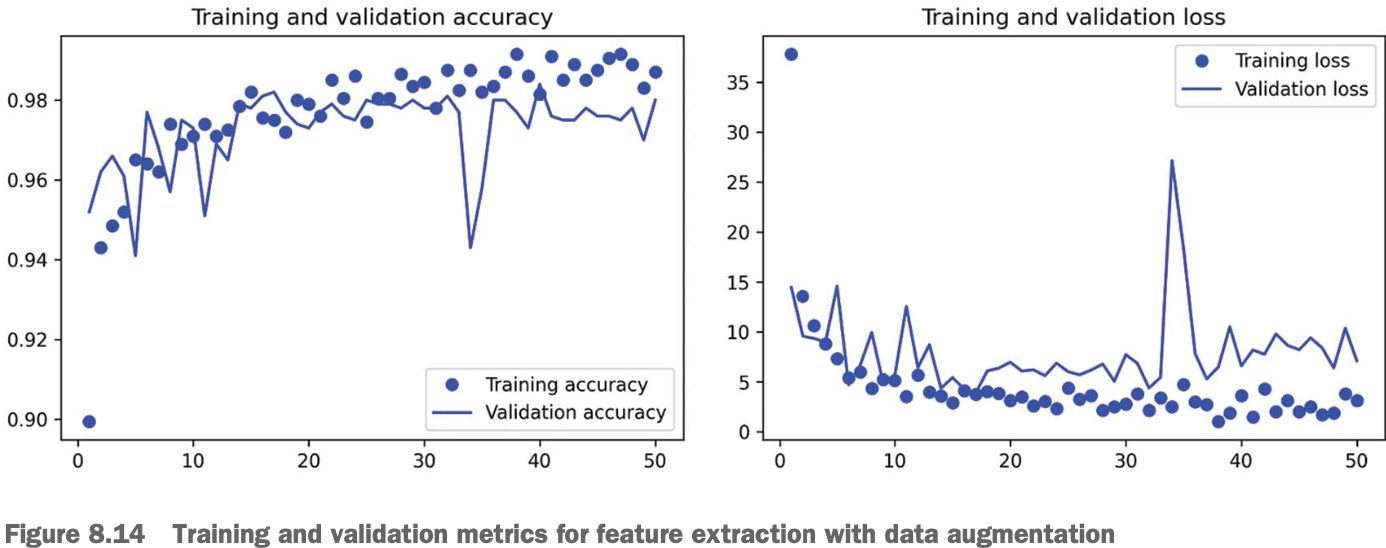

让我们检查一下测试的准确性。

In [58]:
test_model = keras.models.load_model(
            "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

2022-04-06 19:42:54.840776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 24s 365ms/step - loss: 0.7052 - accuracy: 0.9755
Test accuracy: 0.976


我们的测试精度为97.5%。与之前的测试准确性相比，这只是一个适度的提高，鉴于验证数据的强劲结果，这有点令人失望。模型的准确性总是取决于您评估它的样本集！一些样本集可能比其他样本集更困难，一组的强劲结果不一定完全转化为所有其他集。

### 8.3.2 Fine-tuning a pretrained model

另一种广泛使用的模型重用技术是对特征提取的补充，是微调（见图8.15）。微调包括没有冻结的顶层 和 用于特征提取的 `frozen model base`，并联合训练模型新添加的部分（全连接的分类器）和顶层。这被称为微调，因为它略微调整了正在重复使用的模型的更抽象的表示，以使它们与手头的问题更加相关。

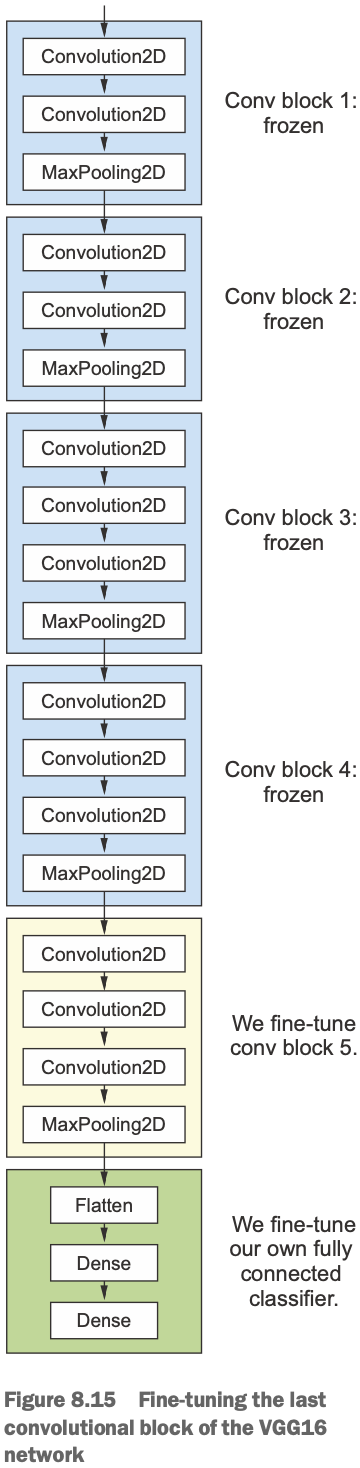

我之前说过，为了能够训练顶部随机初始化的分类器，有必要冻结 VGG16 的 `convolutional base`。出于同样的原因，只有在顶部的分类器经过训练后，才可以微调 `convolutional base` 的顶层。如果分类器尚未训练，则在训练期间通过网络传播的误差信号将过大，之前被微调的层学到的表示将被销毁。因此，微调网络的步骤如下：

- 在已经训练好的基础网络之上添加我们的自定义网络。
- 冻结 base 网络
- 训练添加的部分
- 解冻 base 网络 中的一些层。（请注意，您不应该解冻 “batch normalization” 层，这些层在这里无关，因为VGG16中没有这样的层。下一章将解释 batch normalization 及其对微调的影响。）
- 联合训练这些层和我们添加的部分。

在进行特征提取时，您已经完成了前三个步骤。让我们继续第4步：我们将解冻 `conv_base`，然后冻结其中的个体层。

In [60]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

我们将微调最后三个卷积层，这意味着 `block4_pool` 之前的所有层都应该冻结，`block5_conv1`、`block5_conv2` 和 `block5_conv3` 层应该可以训练。

为什么不微调更多层呢？为什么不微调整个 `convolutional base` 呢？

你可以的。但您需要考虑以下几点：

- `convolutional base` 中的浅层编码更通用、可重用的特征，而上层编码更专业的特征。微调更专业的特征更有用，因为这些特征需要重新用于您的新问题。微调浅层的回报率将迅速下降。
- 您正在训练的参数越多，您就越有可能过拟合。 `convolutional base` 有1500万个参数，因此尝试在小型数据集上训练它是有风险的。

因此，在这种情况下，只微调 `convolutional base` 的前两到三层是一个很好的策略。让我们设置这个，从我们在之前的示例中中断的地方开始。


In [61]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

现在我们可以开始微调模型了。我们将使用 `RMSprop` 优化器，使用非常低的学习率来做到这一点。使用低学习率的原因是，我们希望限制我们对我们正在微调的三层表示所做的修改的规模。过于大的更新可能会损害这些表征。

In [62]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30


2022-04-06 19:49:12.926550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9915

2022-04-06 19:49:44.302363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 44s 674ms/step - loss: 0.2359 - accuracy: 0.9915 - val_loss: 1.1342 - val_accuracy: 0.9780
Epoch 2/30
63/63 [==============================] - 42s 669ms/step - loss: 0.1704 - accuracy: 0.9900 - val_loss: 1.2324 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 42s 662ms/step - loss: 0.1284 - accuracy: 0.9925 - val_loss: 1.1228 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 41s 657ms/step - loss: 0.0587 - accuracy: 0.9955 - val_loss: 0.9373 - val_accuracy: 0.9830
Epoch 5/30
63/63 [==============================] - 41s 658ms/step - loss: 0.1318 - accuracy: 0.9940 - val_loss: 0.9888 - val_accuracy: 0.9770
Epoch 6/30
63/63 [==============================] - 41s 652ms/step - loss: 0.1397 - accuracy: 0.9935 - val_loss: 1.4757 - val_accuracy: 0.9730
Epoch 7/30
63/63 [==============================] - 42s 667ms/step - loss: 0.0739 - accuracy: 0.9955 - val_loss: 0.9321 - val_accuracy: 0.9820
Epoch 8/30

我们终于可以在测试数据上评估这个模型：

In [63]:
model = keras.models.load_model("fine_tuning.keras") 
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

2022-04-06 20:12:16.247557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 23s 362ms/step - loss: 1.0016 - accuracy: 0.9765
Test accuracy: 0.977


在这里，我们的测试准确率为98.5%（同样，您自己的结果可能在一个百分点以内）。在围绕该数据集的原始Kaggle竞争中，这将是最佳结果之一。然而，这不是一个相当公平的比较，因为我们使用了预训练的特征，这些特征已经包含了关于猫和狗的事先知识，而竞争对手当时无法使用。

从积极的方面来看，通过利用现代深度学习技术，我们仅使用可用于比赛的一小部分训练数据（约10%）就达到了这一结果。能够训练20,000个样本与2,000个样本之间存在巨大差异！

现在，您有一套可靠的工具来处理图像分类问题，特别是使用小型数据集。

## Summary

- Convnets是计算机视觉任务的最佳机器学习模型类型。即使在非常小的数据集上，也可以从头开始训练一个，并取得不错的结果。
- Convnets通过学习模块化模式和概念的层次结构来表示视觉世界。
- 在小型数据集上，过拟合将是主要问题。当您处理图像数据时，数据增强是对抗过拟合的有力方法。
- 通过特征提取，很容易在新数据集上重用现有的convnet。这是处理小型图像数据集的宝贵技术。
- 作为特征提取的补充，您可以使用微调来适应现有模型之前学到的一些表示的新问题。这进一步推动了性能。

